# Object Detection

In this tutorial, you will learn:
- the basic structure of Faster R-CNN.
- to perform inference with a MMDetection detector.
- to train a new detector with a new dataset.

Let's start!


## Install MMDetection

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html #torch==1.9.0+cu111

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 847.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 44.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.9.0+cu111 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but 

In [ ]:
!rm -rf mmdetection
!git clone -b 2.x --single-branch https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

Cloning into 'mmdetection'...
remote: Enumerating objects: 25592, done.
remote: Total 25592 (delta 0), reused 0 (delta 0), pack-reused 25592
Receiving objects: 100% (25592/25592), 39.49 MiB | 30.73 MiB/s, done.
Resolving deltas: 100% (17513/17513), done.
/content/mmdetection/mmdetection


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
2.28.2
11.1
GCC 7.3


/usr/local/lib/python3.9/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Perform Inference with An MMDet detector



### A two-stage detector

In this tutorial, we use Faster R-CNN, a simple two-stage detector as an example.

The high-level architecture of Faster R-CNN is shown in the following picture. More details can be found in the [paper](https://arxiv.org/abs/1506.01497).

![faster rcnn](https://pic1.zhimg.com/80/v2-c0172be282021a1029f7b72b51079ffe_1440w.jpg)

![mmdet](https://pic2.zhimg.com/v2-e49ebcf931b5cf424ed311338f9ff35d_b.jpg)

Briefly, it uses a convolutional neural network (CNN) as backbone to extract features from an image. Then, it uses a region proposal network (RPN) to predict proposals, i.e., potential objects. After that, it uses a feature extractor to crop features for the region of interests (RoI), and uses a RoI Head to perform classification and bounding box prediction.



In [ ]:
!mkdir checkpoints
# We download the pre-trained checkpoints for inference and finetuning.
!wget -c https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth \
      -O checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth

--2023-04-20 07:06:36--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.48.85.208, 8.48.85.207, 8.48.85.213, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.48.85.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167291982 (160M) [application/octet-stream]
Saving to: ‘checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’

checkpoints/faster_ 100%[===================>] 159.54M  18.9MB/s    in 8.0s    

2023-04-20 07:06:44 (19.9 MB/s) - ‘checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’ saved [167291982/167291982]



In [ ]:
import mmcv
from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

From the printed model, we will find that the model does consist of the components that we described earlier. It uses ResNet as its CNN backbone, and has a RPN head and RoI Head. In addition, the model has a neural network module, named neck, directly after the CNN backbone. It is a [feature pyramid network (FPN)](https://arxiv.org/abs/1612.03144) for enhancing the multi-scale features.


### Inference the detector

Since the model is successfully created and loaded, let's see how good it is. We use the high-level API `inference_detector` implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/inference.py#L15).

## Train A Detector on A Customized Dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [ ]:
from mmcv import Config
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset. We modify the config of datasets, learning rate schedules, and runtime settings.

In [ ]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.data_root = '/content/drive/MyDrive/agumon/'
classes = ('agumon',)

cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = '/content/drive/MyDrive/agumon/'
#cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = '/content/drive/MyDrive/agumon/test_image'
cfg.data.test.classes = classes

cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = '/content/drive/MyDrive/agumon/'
cfg.data.train.ann_file = '/content/drive/MyDrive/agumon/agumon_detection-coco.json'
cfg.data.train.img_prefix = '/content/drive/MyDrive/agumon/image'
cfg.data.train.classes = classes

cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = '/content/drive/MyDrive/agumon/'
cfg.data.val.ann_file = '/content/drive/MyDrive/agumon/agumon_detection-coco.json'
cfg.data.val.img_prefix = '/content/drive/MyDrive/agumon/image'
cfg.data.val.classes = classes
# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 1
# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = 'checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 1
set_random_seed(1, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

cfg.device='cuda'
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector! We use the high-level API `train_detector` implemented by MMDetection. This is also used in our training scripts. For details of the implementation, please see [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/train.py).

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import os.path as osp


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
model.roi_head.bbox_head.num_classes = 1

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


# Documnet of config
https://mmdetection.readthedocs.io/en/latest/tutorials/config.html


In [ ]:
train_detector(model, datasets, cfg, distributed=False, validate=True)

2023-04-20 07:07:19,929 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2023-04-20 07:07:19,942 - mmdet - INFO - load checkpoint from local path: checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth
2023-04-20 07:07:20,109 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is 

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2023-04-20 07:07:38,042 - mmdet - INFO - Epoch [1][10/17]	lr: 2.500e-03, eta: 0:03:20, time: 1.036, data_time: 0.323, memory: 3489, loss_rpn_cls: 0.0164, loss_rpn_bbox: 0.0096, loss_cls: 0.2213, acc: 95.1074, loss_bbox: 0.1485, loss: 0.3959
2023-04-20 07:07:47,790 - mmdet - INFO - Epoch [2][10/17]	lr: 2.500e-03, eta: 0:01:51, time: 0.670, data_time: 0.251, memory: 3489, loss_rpn_cls: 0.0144, loss_rpn_bbox: 0.0103, loss_cls: 0.0897, acc: 95.7031, loss_bbox: 0.1580, loss: 0.2724
2023-04-20 07:07:57,164 - mmdet - INFO - Epoch [3][10/17]	lr: 2.500e-03, eta: 0:01:24, time: 0.629, data_time: 0.2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 33/33, 8.5 task/s, elapsed: 4s, ETA:     0s

2023-04-20 07:09:35,169 - mmdet - INFO - Evaluating bbox...
2023-04-20 07:09:35,204 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.851
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.969
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.788
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.859
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.880
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.880
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.880
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.833
 Average

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).


From the tensorboard, we can observe that changes of loss and learning rate. We can see the losses of each branch gradually decrease as the training goes by.

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

/content/mmdetection/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


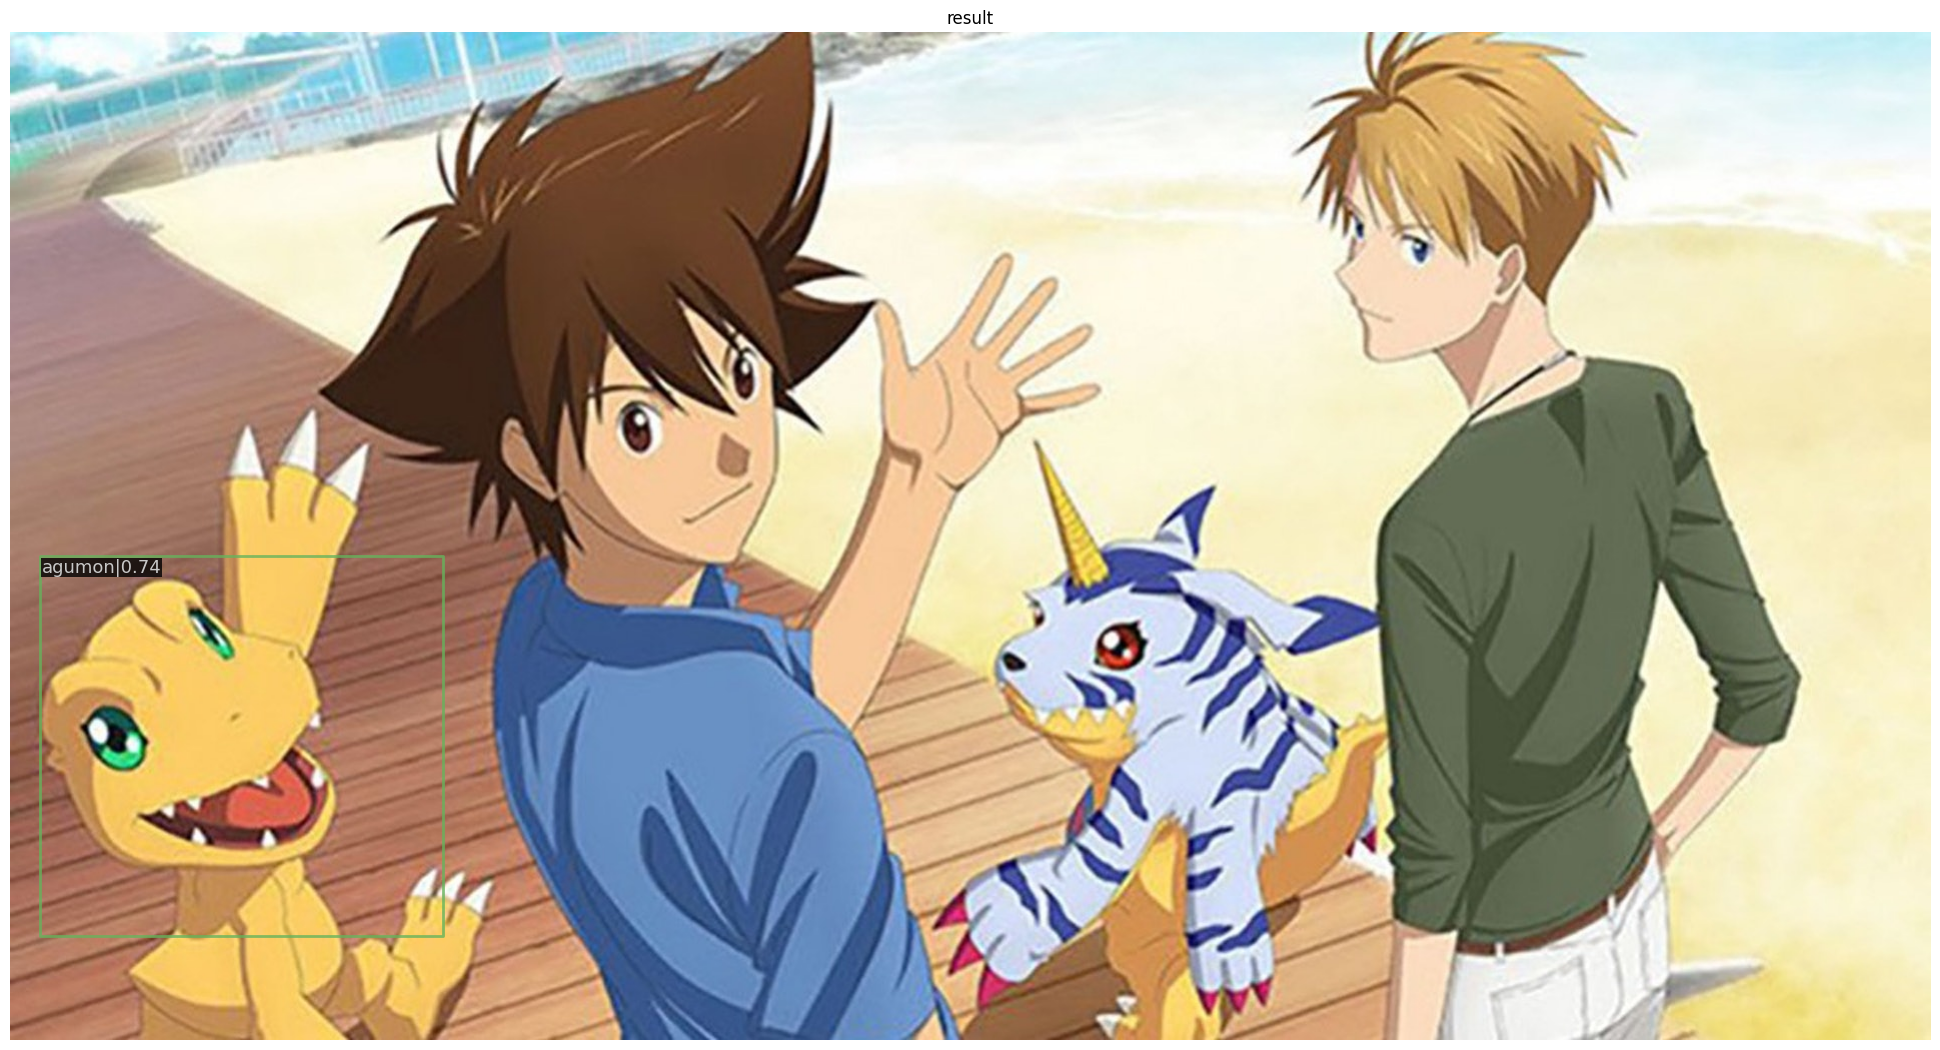

In [ ]:
import os
import torch
import mmcv
from mmdet.apis import inference_detector, init_detector

# Define the input and output directories
input_dir = '/content/drive/MyDrive/agumon/test_image'
output_dir = '/content/drive/MyDrive/agumon/prediction'
model.cfg = cfg
# Get a list of all image files in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith('.jpeg')]

# Loop over each image and make a prediction
for image_file in image_files:
    # Load the image
    img = mmcv.imread(os.path.join(input_dir, image_file))

    # Make a prediction
    result = inference_detector(model, img)
    show_result_pyplot(model, img, result,score_thr=0.7)
    # Save the image with bounding boxes
    output_path = os.path.join(output_dir, image_file)
    mmcv.imwrite(img, output_path)
